In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os

%matplotlib inline

# Helper Functions

In [3]:
def load_pickle_gpyopt(func, seed_size, batch_size, acq_func, eval_type):
    dir_name = "Exp_Data/gpyopt/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch/'
    file_name = dir_name + acq_func + ',' + eval_type + ',results_vars.pickle'
    
    with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
        pickle_dict = pickle.load(f)
        X = pickle_dict["X"]
        min_y = pickle_dict["min_y"]
        
    return X, min_y

# acq_func: "EI" / "EI_MCMC" / "MPI_MCMC" /  "LCB" / "LCB_MCMC"
# evaluator_type: sequential / random  (1st random in Jian's deifnition) / local_penalization / thompson_sampling 

def load_gpyopt_error(func, metric, batch_size, seed_size, acq_func, eval_type):
    x, y = load_pickle_gpyopt(func, seed_size, batch_size, acq_func, eval_type)
    if metric == "L2":
        result = unpack_l2(func, x)
    elif metric == "IR":
        result = unpack_IR(func, y)
        
    if batch_size > 1:
        result = np.repeat(result, repeats = batch_size * np.ones(result.shape[1], dtype = int), axis = 1)
    
    df = np_to_df(result)
    return df

In [4]:
def unpack_IR(func, dic):
    # Used to unpack min_y values from gpyopt pickle dictionary to get Immediate Regret
    max_seed = max(dic.keys()) + 1 # how many seeds
    col_size = dic[0].shape[0] # how many iterations
    
    IR = np.zeros((max_seed, col_size))
    # Minimum y value
    min_y_dict = {
        "hartmann": np.array([-18.22368011]),
        "egg": np.array([-9.596407]),
        "branin": np.array([-14.96021125])
    }
    
    true_min_y = min_y_dict[func] 
    
    for seed_i in range(max_seed):
        current_min_y = dic[seed_i]
        
        if current_min_y.shape[0] == IR.shape[1]: # check whether matches, as gpyopt has errors 
            IR[seed_i,:] = abs(dic[seed_i] - true_min_y).flatten() 
        else:
            print("Seed " + str(seed_i) + " has errors in data.")
            IR[seed_i,:] = np.zeros(IR.shape[1])
    
    IR = IR[~np.all(IR == 0, axis=1)] # remove rows with full zero (errors)      
    return IR

def unpack_l2(func, dic):
    # Used to unpack x values from gpyopt pickle dictionary to get L2 error
    max_seed = max(dic.keys()) + 1 # how many seeds
    col_size = dic[0].shape[0] # how many iterations
    dim = dic[0].shape[1] # input dimensions
    l2_norm = np.zeros((max_seed, col_size))
    
    # Minimiser x value
    min_x_dict = {
        "hartmann": np.array([[0.20169, 0.150011, 0.476874, 0.275332, 0.311652, 0.6573]]),
        "egg": np.array([[1.0, 0.7895]]),
        "branin": np.array([[0.1239, 0.8183],[0.5428, 0.1517],[0.9617, 0.1650]])
    }
    
    true_x_min = min_x_dict[func]
    
    for seed_i in range(max_seed):   
        if func == "branin":
            d1 = np.linalg.norm(true_x_min[0] - dic[seed_i], axis = 1) 
            d2 = np.linalg.norm(true_x_min[1] - dic[seed_i], axis = 1) 
            d3 = np.linalg.norm(true_x_min[2] - dic[seed_i], axis = 1) 
            all_d = np.array([d1, d2, d3])
            l2_distance = np.min(all_d, axis = 0).ravel()
        
        else:
            l2_distance = np.linalg.norm(true_x_min - dic[seed_i], axis = 1).ravel()
            
        if l2_distance.shape[0] == l2_norm.shape[1]: # check whether matches, as gpyopt has errors 
            l2_norm[seed_i,:] = l2_distance
        else:
            print("Seed " + str(seed_i) + " has errors in data.")
            l2_norm[seed_i,:] = np.zeros(l2_norm.shape[1])
        
    l2_norm = l2_norm[~np.all(l2_norm == 0, axis=1)] # remove rows with full zero (errors)
        
    return l2_norm


In [5]:
# Helper functions

def np_to_df(array):
    df = pd.DataFrame(array)
    df = df.stack()
    df = df.to_frame()
    df.index.names = (['seed', 'iters'])
    df.columns = ['values']
    df.reset_index(inplace = True)
    return df

def load_pickle(seed_size, current_seed, func, batch, heuristic, batch_size, target_val):
    if batch == False:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" \
        + str(current_seed) + "_seed/"
        file_name = dir_name + "sequential,intermediate_vars.pickle"

    else:
        dir_name = "Exp_Data/" + func + ',' + str(seed_size) + '_seed,' + str(batch_size) + '_batch_size/' \
        + str(current_seed) + "_seed/"
        file_name = dir_name + heuristic + ',intermediate_vars.pickle'
    
    with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
        pickle_dict = pickle.load(f)
        value = pickle_dict[target_val]
    return value



# Error vs Iterations 

In [6]:
seed_size = 50
batch_sizes = [4]
test_funcs = ["branin","egg", "hartmann"]
# test_funcs = ["hartmann"]
metrics = ["IR", "L2"]
save_file = True

plot_choice = {
        "seq_results": 1, 
        "random_results": 0,
        "random1_results": 1,
        "kb_results": 1,
        "cl_mean_results": 1, 
        "cl_min_results": 1,
        "cl_max_results": 0,
        "gpyopt_localp": 1,
        "gpyopt_sequential": 0,
        }

label_lookup = {
        "seq_results": "Sequential", 
        "random_results": "Fully Random",
        "random1_results": "Random excl. 1st",
        "kb_results": "Kriging Believer",
        "cl_mean_results": "Constant Liar (Mean)", 
        "cl_min_results": "Constant Liar (Min)",
        "cl_max_results": "Constant Liar (Max)",
        "gpyopt_localp": "Local Penalisation",
        "gpyopt_sequential": "Gpyopt Sequential"
        }

metric_lookup = {
        "L2": "L2 norm between actual and guessed x*",
        "IR": "Absolute distance between actual and guessed y*",
        }

estimator = "mean"
#estimator = np.median


      seed  iters    values
0        0      0  4.307186
1        0      1  4.307186
2        0      2  4.307186
3        0      3  4.307186
4        0      4  1.018564
5        0      5  1.018564
6        0      6  1.018564
7        0      7  1.018564
8        0      8  0.790342
9        0      9  0.790342
10       0     10  0.790342
11       0     11  0.790342
12       0     12  0.222666
13       0     13  0.222666
14       0     14  0.222666
15       0     15  0.222666
16       0     16  0.222666
17       0     17  0.222666
18       0     18  0.222666
19       0     19  0.222666
20       0     20  0.222666
21       0     21  0.222666
22       0     22  0.222666
23       0     23  0.222666
24       0     24  0.089848
25       0     25  0.089848
26       0     26  0.089848
27       0     27  0.089848
28       0     28  0.056645
29       0     29  0.056645
...    ...    ...       ...
2170    49     14  0.077476
2171    49     15  0.077476
2172    49     16  0.037527
2173    49     17  0

c:\users\jianhong\anaconda3\envs\tensorflow\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Saved as: Exp_Data/Graphs/4-Batch on branin function (mean, 50 seed)_IR.png
      seed  iters    values
0        0      0  9.564803
1        0      1  9.564803
2        0      2  9.564803
3        0      3  9.564803
4        0      4  5.902598
5        0      5  5.902598
6        0      6  5.902598
7        0      7  5.902598
8        0      8  4.802009
9        0      9  4.802009
10       0     10  4.802009
11       0     11  4.802009
12       0     12  4.132310
13       0     13  4.132310
14       0     14  4.132310
15       0     15  4.132310
16       0     16  1.935849
17       0     17  1.935849
18       0     18  1.935849
19       0     19  1.935849
20       0     20  1.935849
21       0     21  1.935849
22       0     22  1.935849
23       0     23  1.935849
24       0     24  1.935849
25       0     25  1.935849
26       0     26  1.935849
27       0     27  1.935849
28       0     28  1.935849
29       0     29  1.935849
...    ...    ...       ...
2170    49     14  1.122610


Saved as: Exp_Data/Graphs/4-Batch on hartmann function (mean, 50 seed)_L2.png


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

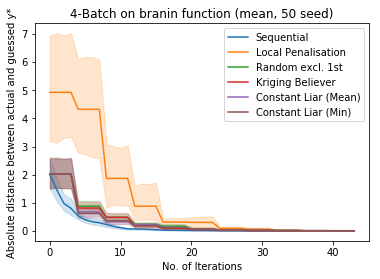

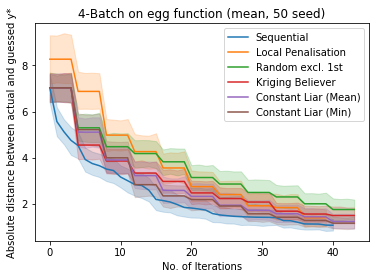

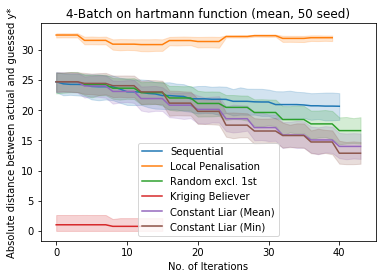

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

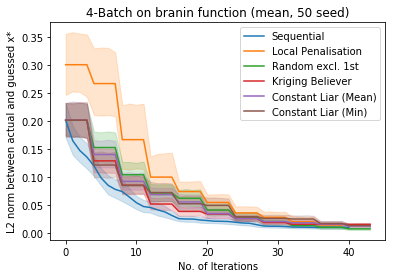

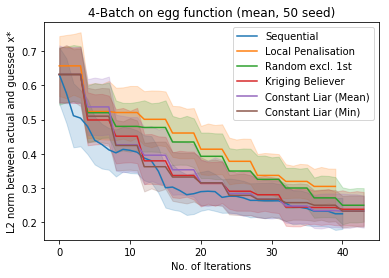

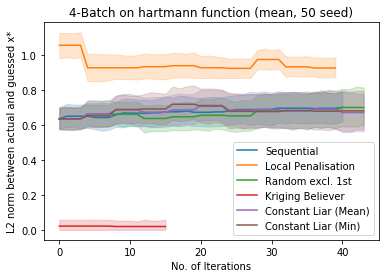

In [7]:

#####
# 1. Error against number of iterations
#####

def error_vs_iterations_v2(func = "egg", seed_size = 2, metrics = "IR", batch = False, batch_size = 2, heuristic = "kb"):
    if batch == False:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed,sequential/" 
        filename = "A_results_" + metrics + ",sequential.npy"
        results = np.load(dir_name + filename)
    else:
        dir_name = "Exp_Data/" + func + "," + str(seed_size) + "_seed," + str(batch_size) + "_batch_size/"
        filename = "A_results_" + metrics + "," + heuristic + "_heuristic.npy"
        results = np.load(dir_name + filename)
        results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
    
    df = np_to_df(results)
    return df
    
if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_v2(batch = False, metrics = metric, func = func, \
                                                         batch_size = batch_size, seed_size = seed_size)
                except: pass
                try:
                    random_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "random")
                except: pass
                try:
                    random1_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "random_except_1st")
                except: pass
                try:
                    kb_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                        batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                    print(cl_min_results)
                except: pass
                try:
                    cl_max_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass
                try:
                    gpyopt_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", "local_penalization")
                except:
                    pass
                """
                try:
                    gpyopt_sequential = load_gpyopt_error(func, metric, 1, seed_size, "EI", "sequential")
                except:
                    pass
                """
                for key, value in plot_choice.items():
                    if value == 1:
                        fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", \
                                           label = label_lookup[key], estimator = estimator)
                
                graph_title = str(batch_size) + "-Batch on "+ str(func) + " function (" + estimator_title + ", " + str(seed_size) + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)

plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)


# Boston Hyperparameter Tuning

Code for gpyopt results

In [62]:
def load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type):
    dir_name = "Exp_Data/boston_" + ml_algo + "/gpyopt/" + str(batch_size) + '_batch/'
    file_name = dir_name + acq_func + ',' + eval_type + ',results_vars.pickle'
    
    with open(file_name, 'rb') as f:  # Python 3: open(..., 'rb')
        pickle_dict = pickle.load(f)
        X = pickle_dict["X"]
        min_y = pickle_dict["min_y"]
        eval_record = pickle_dict["eval_record"]
        
    return X, min_y, eval_record

# acq_func: "EI" / "EI_MCMC" / "MPI_MCMC" /  "LCB" / "LCB_MCMC"
# evaluator_type: sequential / random  (1st random in Jian's deifnition) / local_penalization / thompson_sampling 

def load_gpyopt_error_boston(ml_algo, batch_size, acq_func, eval_type, metric = "error"):
    x, y, eval_record = load_pickle_gpyopt_boston(ml_algo, batch_size, acq_func, eval_type)
    
    # Currently only analysing error
    init = np.reshape(y[0], (1,-1))
    error_array = np.array(init)
    for seed in y:
        results = np.reshape(y[seed], (1,-1))
        error_array = np.vstack((error_array, results))
    error_array = error_array[1:] # remove first one which is duplicate
    
    df = np_to_df(error_array)
    return df

In [63]:
df = load_gpyopt_error_boston("gbr", 2, "EI", "local_penalization")

Code for Batch FITBO

In [ ]:
#####
# 1. Error against number of iterations
#####

def error_vs_iterations_boston(ml_algo, seed_size = 2, batch_size = 2, heuristic = "kb", target_var = "Y_hist"):
    dir_name = "Exp_Data/boston_" + ml_algo + "/fitbo/batch_" + str(batch_size) + "/"
    filename = "batch_" + str(batch_size) + "seed_" + str(seed_size) + "," + heuristic + "," + target_var + ".npy"
    results = np.load(dir_name + filename)
    results = np.repeat(results, repeats = batch_size * np.ones(results.shape[1], dtype = int), axis = 1)
    
    df = np_to_df(results)
    return df
    
if estimator == np.median:
    estimator_title = "median"
else:
    estimator_title = "mean"

def plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file):   
    # Loads, plots and saves graphs     
    for metric in metrics:
        plt.figure() # New figure
        
        for batch_size in batch_sizes:
            plt.figure() # New figure
            
            for func in test_funcs:
                plt.figure()
                try: 
                    seq_results = error_vs_iterations_v2(batch = False, metrics = metric, func = func, \
                                                         batch_size = batch_size, seed_size = seed_size)    
                except: pass
                try:
                    random_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "random")
                except: pass
                try:
                    random1_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "random_except_1st")
                except: pass
                try:
                    kb_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                        batch_size = batch_size, seed_size = seed_size, heuristic = "kb")
                except: pass
                try:
                    cl_mean_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                             batch_size = batch_size, seed_size = seed_size, heuristic = "cl-mean")
                except: pass
                try:
                    cl_min_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-min")
                except: pass
                try:
                    cl_max_results = error_vs_iterations_v2(func = func, metrics = metric, batch = True, \
                                                            batch_size = batch_size, seed_size = seed_size, heuristic = "cl-max")
                except: pass
                try:
                    gpyopt_localp = load_gpyopt_error(func, metric, batch_size, seed_size, "EI", "local_penalization")
                except:
                    pass
                """
                try:
                    gpyopt_sequential = load_gpyopt_error(func, metric, 1, seed_size, "EI", "sequential")
                except:
                    pass
                """
                for key, value in plot_choice.items():
                    if value == 1:
                        fig = sns.lineplot(x = 'iters', y = 'values', data = eval(key), err_style = "band", \
                                           label = label_lookup[key], estimator = estimator)
                
                graph_title = str(batch_size) + "-Batch on "+ str(func) + " function (" + estimator_title + ", " + str(seed_size) + " seed)"
                fig.set(xlabel = "No. of Iterations", ylabel = metric_lookup[metric], title = graph_title)
                save_path = "Exp_Data/Graphs/" + graph_title + "_" + str(metric) + ".png"
                fig2 = fig.get_figure()
                
                if save_file:
                    print("Saved as: " + save_path)
                    
                    if os.path.isfile(save_path): # Remove old files as matplotlib does not overwrite
                        os.remove(save_path)
                        
                    fig2.savefig(save_path)

plot_error_vs_iterations(seed_size, batch_sizes, test_funcs, metrics, plot_choice, save_file)


In [66]:
a = np.load("C:/Users/jianhong/Desktop/4yp-bo/FITBO_GPy-FITBOMM_only/Exp_Data/boston_gbr/fitbo/batch_4/batch_4,seed_30,kb,Y_optimum.npy")

In [69]:
b = np.load("C:/Users/jianhong/Desktop/4yp-bo/FITBO_GPy-FITBOMM_only/Exp_Data/branin,50_seed,4_batch_size/A_results_L2,kb_heuristic.npy")

In [70]:
b

array([[0.34579868, 0.09798298, 0.09798298, 0.09798298, 0.0044644 ,
        0.0044644 , 0.0044644 , 0.0044644 , 0.01674136, 0.01674136,
        0.01674136],
       [0.30906263, 0.14190491, 0.12900739, 0.12900739, 0.01294745,
        0.01294745, 0.01294745, 0.01294745, 0.01294745, 0.0224509 ,
        0.0224509 ],
       [0.21656418, 0.07473739, 0.07473739, 0.07473739, 0.07473739,
        0.07473739, 0.07473739, 0.02381728, 0.02381728, 0.02381728,
        0.02381728],
       [0.34989978, 0.14056861, 0.04660267, 0.04660267, 0.04660267,
        0.03544535, 0.03544535, 0.03544535, 0.03544535, 0.03544535,
        0.03544535],
       [0.16777648, 0.13063075, 0.06182304, 0.01735788, 0.01735788,
        0.01735788, 0.01735788, 0.01735788, 0.01735788, 0.00794514,
        0.00794514],
       [0.11122687, 0.16066666, 0.01692021, 0.01692021, 0.01692021,
        0.01692021, 0.01692021, 0.01692021, 0.01692021, 0.01692021,
        0.00713394],
       [0.18061334, 0.11676693, 0.11677038, 0.04742406, 0.

# Consecutive x's distances 

# Plotting Benchmark Functions

To-do:
- 2D/3D plots of functions (with actual min, past queries)
- Plot current GP model after n queries
- Heatmap for acq func values (for all heuristics)

In [31]:
a = np.array([1,2,3])

In [32]:
a[1:]

array([2, 3])

Exp_Data/egg,30_seed,sequential/0_seed/sequential,intermediate_vars.pickle
(51, 2)


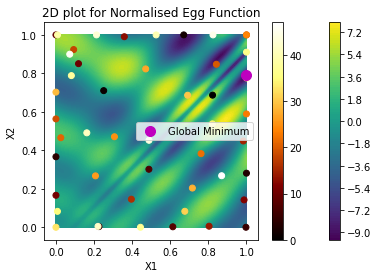

Exp_Data/egg,30_seed,sequential/1_seed/sequential,intermediate_vars.pickle
(51, 2)


<Figure size 432x288 with 0 Axes>

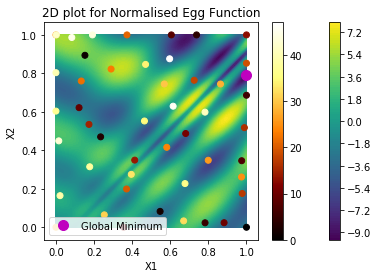

Exp_Data/egg,30_seed,sequential/2_seed/sequential,intermediate_vars.pickle
(51, 2)


<Figure size 432x288 with 0 Axes>

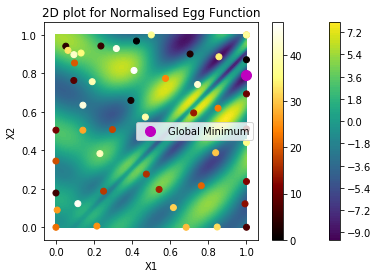

Exp_Data/egg,30_seed,sequential/3_seed/sequential,intermediate_vars.pickle
(51, 2)


<Figure size 432x288 with 0 Axes>

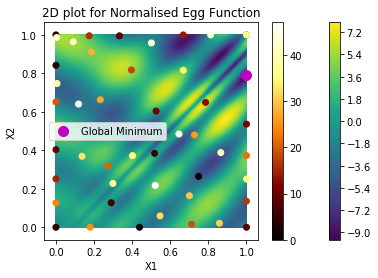

Exp_Data/egg,30_seed,sequential/4_seed/sequential,intermediate_vars.pickle
(51, 2)


<Figure size 432x288 with 0 Axes>

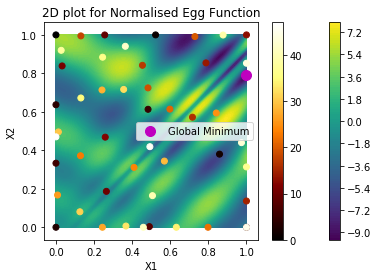

<Figure size 432x288 with 0 Axes>

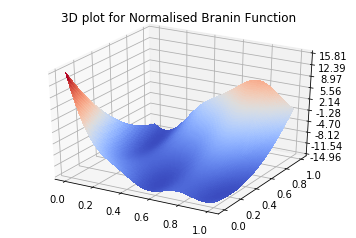

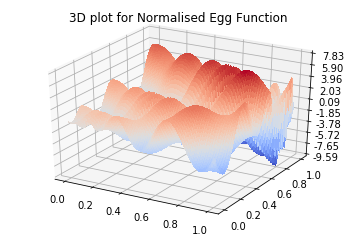